# Creating a CNN model 
1. Implement  initial preprocessing phase
2. Run Word2Vec
3. Create CNN model    
   

## Any pre-required install ments 
* Edit so formal 'if requires package statement

In [1]:
#!pip install nltk
#!pip install gensim
#!pip install torch

#!pip install torch torchvision torchaudio
#import torch
## For windows (possibly):
#!conda install -y -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Anything above 2.10 is not supported on the GPU on Windows Native
#!pip install "tensorflow<2.11"

#!pip install typing-extensions --upgrade
#!pip install Cython
#!conda install -y -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
## Anything above 2.10 is not supported on the GPU on Windows Native
#!pip install tensorflow

## Package imports required
* Edit for formal 'if requires package' statement
* See if can remove pink output/ error message

In [2]:
import nltk
import pickle
import pandas as pd
import requests
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
import string
from nltk.tokenize import word_tokenize
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import wordnet

C:\Users\abbie\Documents\programming\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\abbie\Documents\programming\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Downloading and refining dataset

In [3]:
train_data = pd.read_csv('medical_tc_train.csv')
test_data = pd.read_csv('medical_tc_test.csv')
labels = pd.read_csv('medical_tc_labels.csv')
test_data.head()
train_data['index'] = train_data.index

text_train = train_data['medical_abstract']# preprocess is faster than normalise_text.
y_train = train_data['condition_label']
text_train[:2]
text_test = test_data['medical_abstract']
y_test = test_data['condition_label']

## Preprocessing text
* Put all preporcessing into one cell


In [4]:
#Function from preprocessing file 
### Do this once! Then leave commented next time you run the script.
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('popular')

en_stop = set(stopwords.words('english'))
def preprocess(data):
    data_proc = []
    for doc in data['medical_abstract']:
        #lowercases document
        doc = doc.lower()
        #removes any non-letter characters
        doc = re.sub(r'\b[^a-zA-Z]+\b', ' ', doc)
        #tokenize
        toks = nltk.word_tokenize(doc)
        #remove tokens of lenth <= 1 (can be varied)
        toks = [tok for tok in toks if len(tok) > 1]
        #remove stopwords
        toks = [tok for tok in toks if tok not in en_stop]
        #lemmatize
        toks = [WordNetLemmatizer().lemmatize(tok) for tok in toks]
        data_proc.append(toks)
    return data_proc

In [7]:

X_trains  = preprocess(train_data)
X_tests = preprocess(test_data)
print(X_trains[0])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_trains)

X_train = tokenizer.texts_to_sequences(X_trains)
X_test = tokenizer.texts_to_sequences(X_tests)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
print(X_train[0])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')



['tissue', 'change', 'around', 'loose', 'prosthesis', 'canine', 'model', 'investigate', 'effect', 'antiinflammatory', 'agent', 'aseptically', 'loosened', 'prosthesis', 'provided', 'mean', 'investigating', 'vivo', 'vitro', 'activity', 'cell', 'associated', 'loosening', 'process', 'seven', 'dog', 'cell', 'isolated', 'maintained', 'culture', 'sufficient', 'period', 'time', 'biologic', 'activity', 'could', 'studied', 'well', 'effect', 'different', 'agent', 'added', 'cell', 'vivo', 'vitro', 'biologic', 'response', 'determined', 'interleukin', 'prostaglandin', 'e2', 'activity', 'paralleled', 'roentgenographic', 'appearance', 'loosening', 'technetium', 'image', 'observation', 'made', 'time', 'revision', 'surgery', 'correlation', 'clinical', 'roentgenographic', 'histologic', 'biochemical', 'loosening', 'indicates', 'canine', 'model', 'suitable', 'investigating', 'mechanism', 'prosthetic', 'failure', 'canine', 'model', 'permit', 'study', 'possible', 'nonsurgical', 'therapeutic', 'intervention',

## Word2Vec model
* Consider what each line of code is doing to refine to make sense in context, i.e. is sentence needed?

In [10]:
# Train the Word2Vec model
vocab_size = len(tokenizer.word_index) + 1
w2v_model = Word2Vec(X_trains, vector_size=100, window=5, min_count=1, workers=4)
print(w2v_model)
#w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)


# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]        
print(embedding_matrix.shape)


Word2Vec<vocab=30615, vector_size=100, alpha=0.025>
(30616, 100)


## Evaluation metrics 
* Accuracy 
* Time to run / comparing to other models and on GPU maybe? 

In [11]:
#Accuracy (source mrdbuorke colab link)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [12]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start adn end time. """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end= end_time, device = "cpu")

Train time on cpu: 0.000 seconds


0.00015229999996790866

## CNN model creation

* Print out accuracy 
* Print out predictions vs truths i.e confusion matrix format
* Add time it function 
* Grid search for best hyperparameters

In [13]:

num_classes =5
#create vector of labels 0,4


class CNNMulticlass(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, max_length):
        super(CNNMulticlass, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False #keeps embedidng matrix
        
        self.conv1 = nn.Conv1d(embedding_dim, 256, kernel_size=2)
        self.pool1 = nn.MaxPool1d(5)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=2)
        self.pool2 = nn.MaxPool1d(5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * ((max_length - 4) // 25) , 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
                                                          
        return x


# Create an instance of the CNN model
model_multiclass = CNNMulticlass(vocab_size, 100, embedding_matrix, max_length)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model_multiclass.parameters())
optimizer2 = torch.optim.SGD(params = model_multiclass.parameters(),
                            lr =0.01)
criterion = nn.CrossEntropyLoss()

# Convert data to PyTorch tensors and create DataLoader
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32)



X_test_tensor = torch.LongTensor(X_test)
#print(X_test_tensor[0])
y_test_tensor = torch.LongTensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

#note batch size 32 is common pracitce


### Creating a training loop

In [14]:
from tqdm.auto import tqdm
print(len(test_loader))
train_time_start_on_cpu = timer()

epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch}\n-----")
    train_loss = 0
    for batch, (inputs, labels) in enumerate(train_loader):
        model_multiclass.train()
        # Forward pass'=
        #print(inputs)
        y_pred = model_multiclass(inputs)
        #print(y_pred.softmax(dim=1))
        #Calculate loss
        labels = labels.long() -1
        #print(labels)
        loss = criterion(y_pred, labels)
        train_loss += loss
        #optimizer zero-grad
        optimizer.zero_grad()
        #loss backward      
        loss.backward()
        #step
        optimizer.step()
        
    train_loss /= len(train_loader)
    
    ### Testing
    test_loss, test_acc = 0, 0
    model_multiclass.eval()
    with torch.inference_mode():
        for X_test_tensor, y_test_tensor in test_loader:
            #forward pass
            test_pred = model_multiclass(X_test_tensor)
            #print(y_test_tensor -1)[0,4]
            #calculate loss
            y_test_tensor = y_test_tensor-1 #.Long() 
            test_loss += criterion(test_pred, y_test_tensor)
            #calculate accuracy 
            y_preds = test_pred.argmax(dim=1)
            #print(y_preds)
            test_acc += accuracy_fn(y_true = y_test_tensor, y_pred = y_preds)
        # Calculate the test loss average per batch
        test_loss /= len(test_loader)
        
        # Calculate the test acc average per batch
        test_acc /= len(test_loader)
            
        
        
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    train_time_end_on_cpu = timer()
    total_train_time_model_multiclass = print_train_time(start = train_time_start_on_cpu,
                                              end = train_time_end_on_cpu,
                                              device=str(next(model_multiclass.parameters()).device))


91


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:0
-----

Train loss: 1.1305 | Test loss: 1.0568, Test acc: 55.4602
Train time on cpu: 44.210 seconds
Epoch:1
-----

Train loss: 0.9889 | Test loss: 1.0307, Test acc: 57.3146
Train time on cpu: 96.995 seconds
Epoch:2
-----

Train loss: 0.9343 | Test loss: 1.0349, Test acc: 57.8297
Train time on cpu: 151.254 seconds
Epoch:3
-----

Train loss: 0.8874 | Test loss: 1.0528, Test acc: 57.1085
Train time on cpu: 197.248 seconds
Epoch:4
-----

Train loss: 0.8342 | Test loss: 1.1935, Test acc: 56.1470
Train time on cpu: 252.814 seconds
Epoch:5
-----

Train loss: 0.7712 | Test loss: 1.3179, Test acc: 54.4643
Train time on cpu: 299.796 seconds
Epoch:6
-----

Train loss: 0.7119 | Test loss: 1.4558, Test acc: 53.0220
Train time on cpu: 338.468 seconds
Epoch:7
-----

Train loss: 0.6703 | Test loss: 1.5766, Test acc: 52.0948
Train time on cpu: 386.239 seconds
Epoch:8
-----

Train loss: 0.6226 | Test loss: 1.7303, Test acc: 50.6181
Train time on cpu: 429.974 seconds
Epoch:9
-----

Train loss: 0.5

## Evaluating model 

In [15]:

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn):
  """ Returns a dictionary containing the results pf model prediction on data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y-1)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim =1))

    # Scale loss and acc to find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

#Calculate model 0 results on test dataset
model_multiclass_results = eval_model(model=model_multiclass,
                             data_loader = test_loader,
                             loss_fn = criterion,
                             accuracy_fn = accuracy_fn)
model_multiclass_results

{'model_name': 'CNNMulticlass',
 'model_loss': 2.6977672576904297,
 'model_acc': 8.82554945054945}

Making predictions...:   0%|          | 0/91 [00:00<?, ?it/s]

mlxtend version: 0.23.0
tensor([3, 5, 5,  ..., 4, 1, 4])
tensor([5, 1, 1,  ..., 5, 2, 1])


C:\Users\abbie\Documents\programming\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


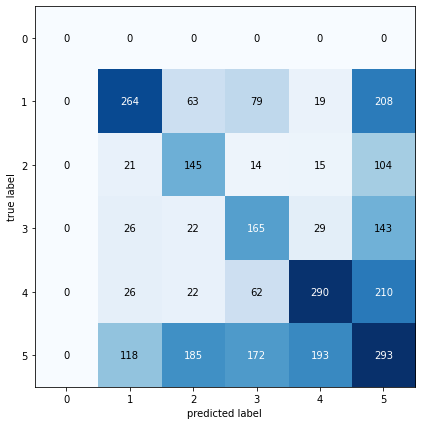

In [16]:
# Import tqdm.auto for progress bar tracking
from tqdm.auto import tqdm

#1. Make predictions with trained model
y_preds = []
model_multiclass.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc = "Making predictions..."):
    # Send the data and targets to target device
    # DO the forward pass
    y_logits = model_multiclass(X)
    #Turn prediction from logits -> prediction porbabilities -> prediction labels
    y_pred = torch.softmax(y_logits.squeeze(), dim =0).argmax(dim=1)+1
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred)

  #COncatenate list of predictions into a tensor
  #print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >=19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f" mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task = "multiclass",
                          num_classes=6)

y_test_tensor = torch.LongTensor(y_test)
print(y_test_tensor)
print(y_pred_tensor)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = y_test_tensor)

#3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), #matplotlib likes working with numpy
    figsize=(10,7)
)

#### Edit confusion matrix to get rid of class 0